# Sound-Induced Flash Illusion

In this example we show how we can compare models in an audio-visual temporal disparity task to reproduce the Sound-Induced Flash Illusion as shown in:

>Cuppini, C., Magosso, E., Bolognini, N., Vallar, G., & Ursino, M. (2014). A neurocomputational analysis of the sound-induced flash illusion. Neuroimage, 92, 248-266. doi: https://doi.org/10.1016/j.neuroimage.2014.02.001

>Zhu, H., Beierholm, U., & Shams, L. (2024). The overlooked role of unisensory precision in multisensory research. Current Biology, 34(6), R229-R231. doi:  https://doi.org/10.1016/j.cub.2024.01.057 

>Paredes, R., Ferri, F., Romei, V., & Seriès, P. (2025). Increased excitation enhances the sound-induced flash illusion by impairing multisensory causal inference in the schizophrenia spectrum. Schizophrenia Research, 283, 1-10. doi: https://doi.org/10.1016/j.schres.2025.06.007

## Implementation of models

For this paradigm we call the relevant models that account for temporal multisensory integration:

In [ ]:
from skneuromsi.bayesian import Zhu2024
from skneuromsi.neural import Cuppini2014
from skneuromsi.neural import Paredes2025

model_cuppini = Cuppini2014(
    time_range=(0, 550), neurons=30, position_range=(0, 30)
)

model_zhu = Zhu2024(
    n=100000,
    time_range=(0, 1000),
    time_res=1,
    numerosity_range=(0, 3),
    numerosity_res=1,
)

model_paredes = Paredes2025(
    time_range=(0, 550),
    neurons=30,
    position_range=(0, 30),
    tau=(6.560e00, 9.191e00, 1.200e02),
)

## Experiment setup

We are interested to explore the visual illusion rate and causal inference responses when two auditory stimuli (beeps) and one visual stimulus (flash) are presented at different stimuli onset asynchronies (SOA).

To simulate the visual illusion rate we define customized `ProcessingStrategy` routines. These routines depend on specific helper functions that are necessary to handle inputs and outputs of each model.

In [80]:
import itertools
import numpy as np
from skneuromsi.sweep import ProcessingStrategyABC
from scipy.signal import find_peaks


def calculate_auditory_times(visual_time, soas, auditory_stim_duration=17):
    a_times = []
    for soa in soas:
        if soa > 0:
            a_start = visual_time - auditory_stim_duration / 2
            a_end = (
                visual_time
                + auditory_stim_duration / 2
                + soa
                + auditory_stim_duration
            )
        if soa < 0:
            a_start = visual_time - auditory_stim_duration / 2 + soa - 17
            a_end = visual_time + auditory_stim_duration / 2
        a_stim_train_duration = a_end - a_start
        a_time = a_start + a_stim_train_duration / 2
        a_times.append(a_time)
    return np.array(a_times)


def calculate_two_peaks_probability(visual_peaks_values):
    combinations = list(
        itertools.chain.from_iterable(
            itertools.combinations(visual_peaks_values, i + 2)
            for i in range(len(visual_peaks_values))
        )
    )

    probs_array = np.array([], dtype=np.float16)

    for i in combinations:
        probs_array = np.append(probs_array, np.array(i).prod())

    return probs_array.sum() / probs_array.size


class BayesianIllusionRateProcessingStrategy(ProcessingStrategyABC):
    def map(self, result):
        e_visual_numerosity = result.e_["visual_numerosity"]
        two_flashes_prop = e_visual_numerosity[2]
        del result._nddata
        return two_flashes_prop

    def reduce(self, results, **kwargs):
        return np.array(results)


class NeuralIllusionRateProcessingStrategy(ProcessingStrategyABC):
    def map(self, result):
        max_pos = result.stats.dimmax().positions
        visual_activity = (
            result.get_modes(include="visual")
            .query(f"positions=={max_pos}")
            .visual.values
        )
        peaks, peaks_props = find_peaks(
            visual_activity,
            height=0.15,
            prominence=0.15,
            distance=36 / 0.01,
        )
        if len(peaks) < 2:
            p_two_flashes = 0
        else:
            p_two_flashes = calculate_two_peaks_probability(
                peaks_props["peak_heights"]
            )
        del visual_activity, peaks, peaks_props, max_pos
        del result._nddata
        return p_two_flashes

    def reduce(self, results, **kwargs):
        return np.array(results, dtype=np.float16)

Now we setup the experiment simulation for each model using the `ParameterSweep` class:

In [84]:
from skneuromsi.sweep import ParameterSweep

soas = np.array(
    [36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204]
)
zhu_auditory_times = calculate_auditory_times(
    soas=soas, auditory_stim_duration=7, visual_time=16
)

cuppini_sp = ParameterSweep(
    model=model_cuppini,
    target="soa",
    repeat=1,
    n_jobs=-2,
    range=soas,
    processing_strategy=NeuralIllusionRateProcessingStrategy(),
)

zhu_sp = ParameterSweep(
    model=model_zhu,
    target="auditory_time",
    range=zhu_auditory_times,
    repeat=1,
    n_jobs=-2,
    processing_strategy=BayesianIllusionRateProcessingStrategy(),
)

paredes_sp = ParameterSweep(
    model=model_paredes,
    target="auditory_soa",
    repeat=1,
    n_jobs=-2,
    range=soas,
    processing_strategy=NeuralIllusionRateProcessingStrategy(),
)

## Visual illusion responses

We are now ready to run the experiment and extract visual illusion responses for each model:

In [85]:
cuppini_res = cuppini_sp.run(
    auditory_intensity=2.5,
    visual_intensity=1.5,
    onset=16,
    auditory_stim_n=2,
    visual_stim_n=1,
    auditory_duration=7,
    visual_duration=12,
    noise=False,
)

zhu_res = zhu_sp.run(
    visual_time=16,
    auditory_time_sigma=7.0,
    visual_time_sigma=12.0,
    auditory_numerosity=2,
    visual_numerosity=1,
    auditory_numerosity_sigma=0.12,
    visual_numerosity_sigma=0.60,
    prior_time_sigma=40.0,
    prior_time_mu=100.0,
    prior_numerosity_mu=1.5,
    prior_numerosity_sigma=0.45,
    noise=True,
    p_common=0.6,
)

paredes_res = paredes_sp.run(
    auditory_intensity=2.325,
    visual_intensity=1.45,
    auditory_stim_n=2,
    visual_stim_n=1,
    auditory_duration=7,
    visual_duration=12,
    noise=False,
    lateral_excitation=0.5,
    lateral_inhibition=0.4,
    cross_modal_weight=1.036e-03,
    feedback_weight=6.231e-01,
    feedforward_weight=3.892e00,
)

Sweeping 'soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_time':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

## Plotting

Finally we plot our results to visually compare the performance of the models:

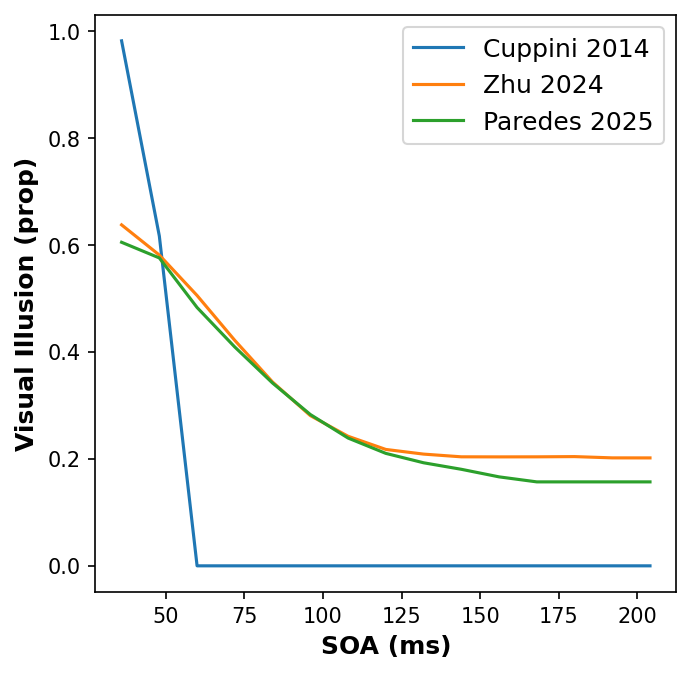

In [87]:
import matplotlib.pyplot as plt

# initializes figure and plots
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Panel A
ax1 = plt.subplot(111)
ax1.plot(soas, cuppini_res)
ax1.plot(soas, zhu_res)
ax1.plot(soas, paredes_res)
ax1.set_xlabel("SOA (ms)", size=12, weight="bold")
ax1.set_ylabel("Visual Illusion (prop)", size=12, weight="bold")
ax1.tick_params(axis="both", labelsize=10)

legend = ax1.legend(
    [
        "Cuppini 2014",
        "Zhu 2024",
        "Paredes 2025",
    ],
    fontsize=12,
)